# Final Twitter Analysis Report

By Atwine Mugume Twinamatsiko

- Project: Using Twitter Data Analysis to inform policy.
- Date: 1-Sept-2020 - 31-Oct-2020

I have used a new notebook because here I want to organize all the scattered thoughts in the rest of the notebooks in one place.

In [1]:
#Import all the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import re
import collections
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("updated_data.csv")

In [3]:
#I had already removed the duplicates in the data from my laptop
#What are the total dimensions of the data
data.shape

(944463, 19)

In [4]:
#let us look at the head of the data to see the columns
data.head(3)

Tweet Id Tweet Posted Time (UTC)  \
0  "1316880875116761088"     2020-10-15 23:17:21   
1  "1316852001716797440"     2020-10-15 21:22:37   
2  "1316843372569657346"     2020-10-15 20:48:20   

                                                text Retweeted Screen Name  \
0  RT @Tim_jbo: #SkyNewsAust being completely tru...               Tim_jbo   
1  RT @AAssimwe: “What makes @NRMOnline financial...              AAssimwe   
2  “What makes @NRMOnline financially secure to t...                   NaN   

  Tweet Type               Client Retweets Received Favourites Received  \
0    ReTweet                  NaN                 0                   0   
1    ReTweet  Twitter for Android                 0                   0   
2      Tweet   Twitter for iPhone                 9                  16   

    Tweet Location Tweet Language             Name     Screen Name  \
0  Kampala, Uganda        English        Jane Eden      jane__eden   
1  Kampala, Uganda        English  Kakwenza Rukira  KakwenzaRukira   
2           UGANDA        English  Angella Asiimwe        AAssimwe   

  Verified or Non-Verified  User Followers  User Following Favourites Count  \
0             Non-Verified           894.0           660.0             1529   
1             Non-Verified           983.0           259.0             3968   
2             Non-Verified          7322.0          5041.0             5667   

   Statuses Count User Account Creation Date                 date  
0         94125.0       12 Aug 2020 11:30:19  2020-10-15 23:17:21  
1          5023.0       22 Dec 2018 09:03:55  2020-10-15 21:22:37  
2         18657.0       10 Sep 2014 10:42:48  2020-10-15 20:48:20

In [5]:
#let me make a copy of the data so I can have one remain un touched
twen = data.copy(deep=True)

From here let us look at the composition of the data we have, this is more like descriptive of the kind of information that we have.

In [6]:
#first let me rename tweet content as text
twen.rename(columns={'Tweet Content':'text'},inplace=True)

In [7]:
#check if the column has changed
twen.head(3)

Tweet Id Tweet Posted Time (UTC)  \
0  "1316880875116761088"     2020-10-15 23:17:21   
1  "1316852001716797440"     2020-10-15 21:22:37   
2  "1316843372569657346"     2020-10-15 20:48:20   

                                                text Retweeted Screen Name  \
0  RT @Tim_jbo: #SkyNewsAust being completely tru...               Tim_jbo   
1  RT @AAssimwe: “What makes @NRMOnline financial...              AAssimwe   
2  “What makes @NRMOnline financially secure to t...                   NaN   

  Tweet Type               Client Retweets Received Favourites Received  \
0    ReTweet                  NaN                 0                   0   
1    ReTweet  Twitter for Android                 0                   0   
2      Tweet   Twitter for iPhone                 9                  16   

    Tweet Location Tweet Language             Name     Screen Name  \
0  Kampala, Uganda        English        Jane Eden      jane__eden   
1  Kampala, Uganda        English  Kakwenza Rukira  KakwenzaRukira   
2           UGANDA        English  Angella Asiimwe        AAssimwe   

  Verified or Non-Verified  User Followers  User Following Favourites Count  \
0             Non-Verified           894.0           660.0             1529   
1             Non-Verified           983.0           259.0             3968   
2             Non-Verified          7322.0          5041.0             5667   

   Statuses Count User Account Creation Date                 date  
0         94125.0       12 Aug 2020 11:30:19  2020-10-15 23:17:21  
1          5023.0       22 Dec 2018 09:03:55  2020-10-15 21:22:37  
2         18657.0       10 Sep 2014 10:42:48  2020-10-15 20:48:20

In [8]:
#See the percentage of tweets from the initial set that are #retweets:
RT_tweets = twen[twen['text'].str.contains("RT", na=False)]
print(f"The percentage of retweets is {round(len(RT_tweets)/len(twen)*100)}% of all the tweets")

The percentage of retweets is 76% of all the tweets


In [9]:
#See the percentage of tweets from the initial set that have #mentions and are not retweets:
mention_tweets = twen[~twen['text'].str.contains("RT", na = False)  & twen['text'].str.contains("@", na = False)]
print(f"The percentage of mentions is {round(len(mention_tweets)/len(twen)*100)}% of all the tweets")

The percentage of mentions is 11% of all the tweets


In [10]:
#See how many tweets inside are plain text tweets (No RT or mention)
plain_text_tweets = twen[~twen['text'].str.contains("@", na = False)  & ~twen['text'].str.contains("RT", na = False)]
print(f"The percentage of plain text is {round(len(plain_text_tweets)/len(twen)*100)}% of all the tweets")

The percentage of plain text is 13% of all the tweets


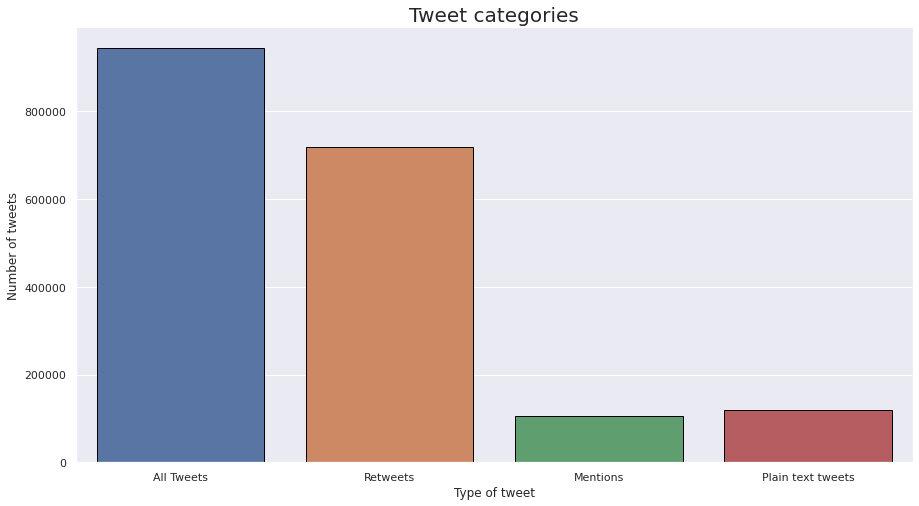

In [11]:
#Now we will plot all the different categories. Note that the reply #tweets are inside the mention tweets
len_list = [ len(twen), len(RT_tweets),len(mention_tweets), len(plain_text_tweets)]
item_list = ['All Tweets','Retweets', 'Mentions', 'Plain text tweets']
plt.figure(figsize=(15,8))
sns.set(style="darkgrid")
plt.title('Tweet categories', fontsize = 20)
plt.xlabel('Type of tweet')
plt.ylabel('Number of tweets')
sns.barplot(x = item_list, y = len_list,  edgecolor = 'black', linewidth=1)

plt.show()

In [12]:
#let us check the most used hash tags

In [13]:
#if we skip this step we shall have an error compiling with regular expressions
#so this is a must if one wants to move smoothly in the analysis
twen.text = twen.text.astype('str')

In [14]:
#To see the most used hashtags.
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z]+")
hashtag_matches = list(twen['text'].apply(hashtag_pattern.findall))
hashtag_dict = {}
for match in hashtag_matches:
    for singlematch in match:
        if singlematch not in hashtag_dict.keys():
            hashtag_dict[singlematch] = 1
        else:
            hashtag_dict[singlematch] = hashtag_dict[singlematch]+1

In [15]:
#Making a list of the most used hashtags and their values
hashtag_ordered_list =sorted(hashtag_dict.items(), key=lambda x:x[1])
hashtag_ordered_list = hashtag_ordered_list[::-1]
#Separating the hashtags and their values into two different lists
hashtag_ordered_values = []
hashtag_ordered_keys = []
#Pick the 5 most used hashtags to plot
for item in hashtag_ordered_list[0:5]:
    hashtag_ordered_keys.append(item[0])
    hashtag_ordered_values.append(item[1])

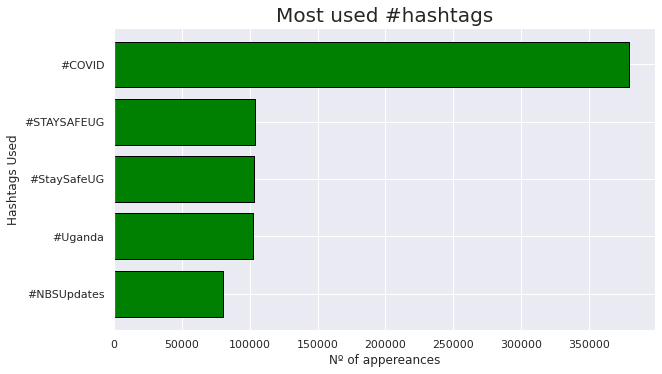

In [16]:
#Plotting a graph with the most used hashtags
fig, ax = plt.subplots(figsize = (10,6))
y_pos = np.arange(len(hashtag_ordered_keys))
ax.barh(y_pos ,list(hashtag_ordered_values)[::-1], align='center', color = 'green', edgecolor = 'black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
ax.set_xlabel("Nº of appereances")
ax.set_ylabel("Hashtags Used")
ax.set_title("Most used #hashtags", fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

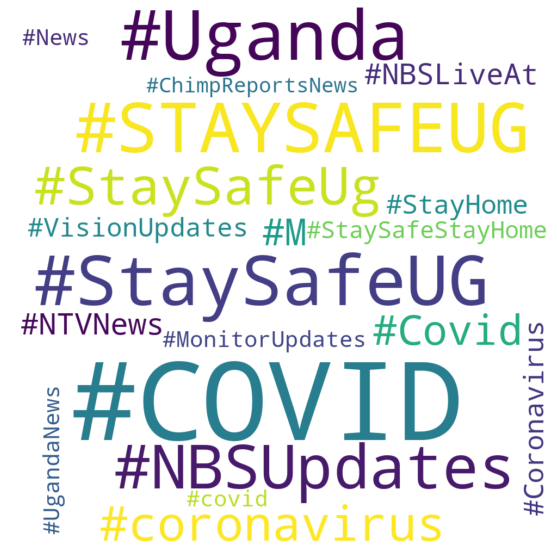

In [17]:
#Make a wordcloud plot of the most used hashtags, for this we need a #dictionary 
#where the keys are the words and the values are the number of #appearances
hashtag_ordered_dict = {}
for item in hashtag_ordered_list[0:20]:
    hashtag_ordered_dict[item[0]] = item[1]
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(hashtag_ordered_dict)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

In [18]:
#tweet counts should tell us what things have been looking like per month

In [19]:
twen.head(3)

Tweet Id Tweet Posted Time (UTC)  \
0  "1316880875116761088"     2020-10-15 23:17:21   
1  "1316852001716797440"     2020-10-15 21:22:37   
2  "1316843372569657346"     2020-10-15 20:48:20   

                                                text Retweeted Screen Name  \
0  RT @Tim_jbo: #SkyNewsAust being completely tru...               Tim_jbo   
1  RT @AAssimwe: “What makes @NRMOnline financial...              AAssimwe   
2  “What makes @NRMOnline financially secure to t...                   NaN   

  Tweet Type               Client Retweets Received Favourites Received  \
0    ReTweet                  NaN                 0                   0   
1    ReTweet  Twitter for Android                 0                   0   
2      Tweet   Twitter for iPhone                 9                  16   

    Tweet Location Tweet Language             Name     Screen Name  \
0  Kampala, Uganda        English        Jane Eden      jane__eden   
1  Kampala, Uganda        English  Kakwenza Rukira  KakwenzaRukira   
2           UGANDA        English  Angella Asiimwe        AAssimwe   

  Verified or Non-Verified  User Followers  User Following Favourites Count  \
0             Non-Verified           894.0           660.0             1529   
1             Non-Verified           983.0           259.0             3968   
2             Non-Verified          7322.0          5041.0             5667   

   Statuses Count User Account Creation Date                 date  
0         94125.0       12 Aug 2020 11:30:19  2020-10-15 23:17:21  
1          5023.0       22 Dec 2018 09:03:55  2020-10-15 21:22:37  
2         18657.0       10 Sep 2014 10:42:48  2020-10-15 20:48:20

In [20]:
#I am going to create a new column called date and make it the index
try:
    twen['date'] = pd.to_datetime(twen['Tweet Posted Time (UTC)'])
except ParserError:
    print("ParseError")

"""
The syntax above is not compulsory, I was having some issues working with data from different
timezones as a result I had to skip some of these rows that were creating a problem hence the
code above. 
"""    
    
    

In [21]:
#after I convert the time to date time
#I need the column below because once I make the date column index I will still need to get months
#the issue is that the index is not considered a column so I can reference from it. Hence the col below
twen['Tweet Posted Time (UTC)'] = pd.to_datetime(twen['Tweet Posted Time (UTC)'])

In [54]:
#I am keeping the data here so that I don't have to go through the issues again
#twen.to_csv('updated_data.csv',index=False)

In [22]:
#now I am going to change the index to Date
twen.set_index('date', inplace = True)

"""
It should be noted that when you want to plot time series its important to have the index of 
your data as a pandas datetime data type otherwise you will have issues.

It is actually good that you create a separate date column because once the date is an index its
no longer considered a colum. Therefore If you want some time functions it will be hard for you.
"""

In [23]:
twen.rename(columns={'Tweet Posted Time (UTC)':'time'},inplace=True)
twen.head(2)

Tweet Id                time  \
date                                                             
2020-10-15 23:17:21  "1316880875116761088" 2020-10-15 23:17:21   
2020-10-15 21:22:37  "1316852001716797440" 2020-10-15 21:22:37   

                                                                  text  \
date                                                                     
2020-10-15 23:17:21  RT @Tim_jbo: #SkyNewsAust being completely tru...   
2020-10-15 21:22:37  RT @AAssimwe: “What makes @NRMOnline financial...   

                    Retweeted Screen Name Tweet Type               Client  \
date                                                                        
2020-10-15 23:17:21               Tim_jbo    ReTweet                  NaN   
2020-10-15 21:22:37              AAssimwe    ReTweet  Twitter for Android   

                    Retweets Received Favourites Received   Tweet Location  \
date                                                                         
2020-10-15 23:17:21                 0                   0  Kampala, Uganda   
2020-10-15 21:22:37                 0                   0  Kampala, Uganda   

                    Tweet Language             Name     Screen Name  \
date                                                                  
2020-10-15 23:17:21        English        Jane Eden      jane__eden   
2020-10-15 21:22:37        English  Kakwenza Rukira  KakwenzaRukira   

                    Verified or Non-Verified  User Followers  User Following  \
date                                                                           
2020-10-15 23:17:21             Non-Verified           894.0           660.0   
2020-10-15 21:22:37             Non-Verified           983.0           259.0   

                    Favourites Count  Statuses Count  \
date                                                   
2020-10-15 23:17:21             1529         94125.0   
2020-10-15 21:22:37             3968          5023.0   

                    User Account Creation Date  
date                                            
2020-10-15 23:17:21       12 Aug 2020 11:30:19  
2020-10-15 21:22:37       22 Dec 2018 09:03:55

In [24]:
#here I take out the variables that are partaining to different times.
#lets create a day variable
twen['Day'] = twen.time.dt.date

twen['Hour'] = twen.time.dt.hour

#this is a visual of the total tweets per hour for the data we have.
twen['WeekDay'] = twen.time.dt.day_name()

In [25]:
twen.head(4)

Tweet Id                time  \
date                                                             
2020-10-15 23:17:21  "1316880875116761088" 2020-10-15 23:17:21   
2020-10-15 21:22:37  "1316852001716797440" 2020-10-15 21:22:37   
2020-10-15 20:48:20  "1316843372569657346" 2020-10-15 20:48:20   
2020-10-15 19:01:46  "1316816553480990721" 2020-10-15 19:01:46   

                                                                  text  \
date                                                                     
2020-10-15 23:17:21  RT @Tim_jbo: #SkyNewsAust being completely tru...   
2020-10-15 21:22:37  RT @AAssimwe: “What makes @NRMOnline financial...   
2020-10-15 20:48:20  “What makes @NRMOnline financially secure to t...   
2020-10-15 19:01:46  RT @ECA_OFFICIAL: About $4.6billion in #DSSI l...   

                    Retweeted Screen Name Tweet Type               Client  \
date                                                                        
2020-10-15 23:17:21               Tim_jbo    ReTweet                  NaN   
2020-10-15 21:22:37              AAssimwe    ReTweet  Twitter for Android   
2020-10-15 20:48:20                   NaN      Tweet   Twitter for iPhone   
2020-10-15 19:01:46          ECA_OFFICIAL    ReTweet      Twitter Web App   

                    Retweets Received Favourites Received   Tweet Location  \
date                                                                         
2020-10-15 23:17:21                 0                   0  Kampala, Uganda   
2020-10-15 21:22:37                 0                   0  Kampala, Uganda   
2020-10-15 20:48:20                 9                  16           UGANDA   
2020-10-15 19:01:46                 0                   0   Kampala@Uganda   

                    Tweet Language  ...      Screen Name  \
date                                ...                    
2020-10-15 23:17:21        English  ...       jane__eden   
2020-10-15 21:22:37        English  ...   KakwenzaRukira   
2020-10-15 20:48:20        English  ...         AAssimwe   
2020-10-15 19:01:46        English  ...  KiapiKFreddie76   

                    Verified or Non-Verified User Followers  User Following  \
date                                                                          
2020-10-15 23:17:21             Non-Verified          894.0           660.0   
2020-10-15 21:22:37             Non-Verified          983.0           259.0   
2020-10-15 20:48:20             Non-Verified         7322.0          5041.0   
2020-10-15 19:01:46             Non-Verified         2411.0          5002.0   

                     Favourites Count Statuses Count  \
date                                                   
2020-10-15 23:17:21              1529        94125.0   
2020-10-15 21:22:37              3968         5023.0   
2020-10-15 20:48:20              5667        18657.0   
2020-10-15 19:01:46             20150        27264.0   

                     User Account Creation Date         Day  Hour   WeekDay  
date                                                                         
2020-10-15 23:17:21        12 Aug 2020 11:30:19  2020-10-15  23.0  Thursday  
2020-10-15 21:22:37        22 Dec 2018 09:03:55  2020-10-15  21.0  Thursday  
2020-10-15 20:48:20        10 Sep 2014 10:42:48  2020-10-15  20.0  Thursday  
2020-10-15 19:01:46        16 May 2012 23:27:50  2020-10-15  19.0  Thursday  

[4 rows x 21 columns]

<AxesSubplot:title={'center':'Tweet Count Per Week Day'}, xlabel='WeekDay', ylabel='Tweet Count'>

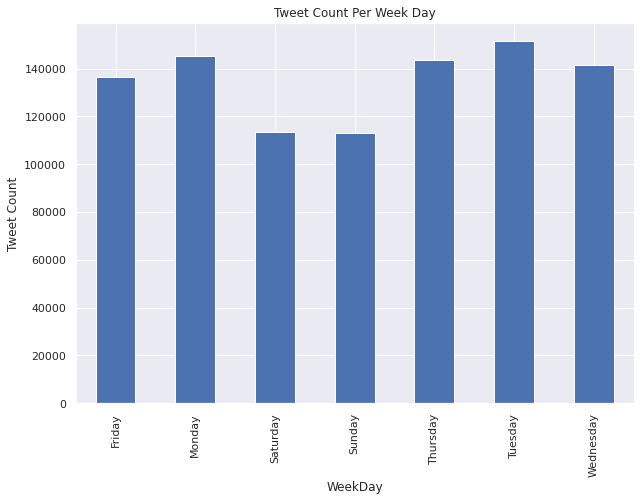

In [26]:
#plot the graph that shows how the count was daily.
plt.figure(figsize = (10,7))
plt.title("Tweet Count Per Week Day")
plt.ylabel("Tweet Count")
twen.groupby('WeekDay').count()['Tweet Id'].plot(kind = 'bar')

<AxesSubplot:title={'center':'Count of Tweets Per Hour'}, xlabel='Hour', ylabel='Count Per Hour'>

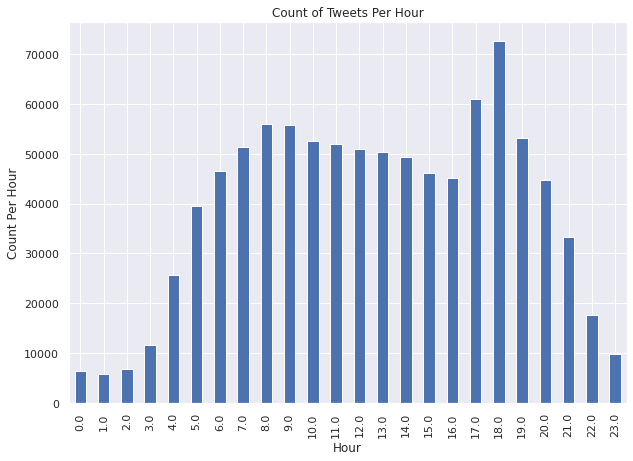

In [27]:
plt.figure(figsize = (10,7))
plt.title("Count of Tweets Per Hour")
plt.ylabel("Count Per Hour")
twen.groupby('Hour').count()['Tweet Id'].plot(kind ='bar')

<AxesSubplot:title={'center':'Tweet Count Per Month'}, xlabel='Month', ylabel='Tweet Count'>

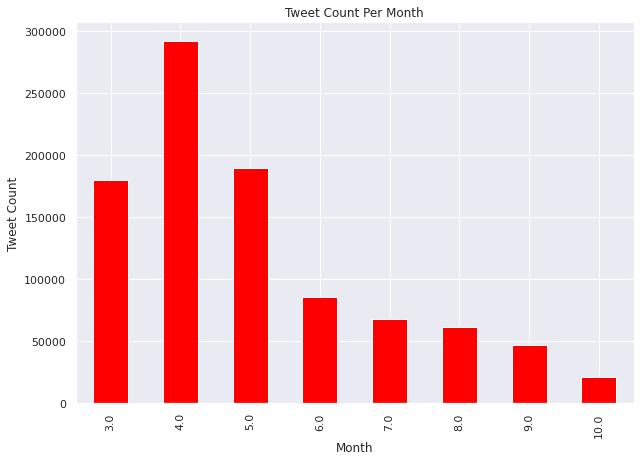

In [28]:
#this is a visual of the total tweets per day for the data we have.
plt.figure(figsize = (10,7))
plt.title("Tweet Count Per Month")
plt.ylabel("Tweet Count")
twen['Month'] = twen.time.dt.month

twen.groupby('Month').count()['Tweet Id'].plot(kind ='bar',grid=True, color='red')

In [29]:
#what is the total number of tweets concerning corona

In [30]:
def check_word_in_tweet(word, data):
    """Checks if a word is in a Twitter dataset's text. 
    Checks text and extended tweet (140+ character tweets) for tweets,
    retweets and quoted tweets.
    Returns a logical pandas Series.
    """
    contains_column = data['text'].str.contains(word, case = False)
    return contains_column

In [31]:
sum(check_word_in_tweet('corona',twen))/twen.shape[0]*100 +\
sum(check_word_in_tweet('covid',twen))/twen.shape[0]*100 

#this is the percentage of the data that contains covid and corona information.

77.58472274721191

### Sentiment analysis

Before we can work with text data we have to clean it up, that means removing contents of text that may not be informative in our analysis.

I did not use some of the methods like lematizing and stemming for this analysis, and this is an option that we could explore some other time.

In [33]:
#convert tweets to lower case
twen['preprocess_data'] = twen['text'].str.lower()

In [34]:
#url removes
twen['preprocess_data'] = twen['preprocess_data'].str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')
twen['preprocess_data'] = twen['preprocess_data'].str.replace(r'www\.\S+\.com','')

In [35]:
#removes retweets & cc
twen['preprocess_data'] = twen['preprocess_data'].str.replace(r'rt|cc', '')

In [36]:
#hashtags removes 
twen['preprocess_data'] = twen['preprocess_data'].str.replace(r'#\S+', '')

In [37]:
#user mention removes
twen['preprocess_data'] = twen['preprocess_data'].str.replace(r'@\S+', '')

In [38]:
#emoji 
twen['preprocess_data'] = twen['preprocess_data'].str.replace(r'[^\x00-\x7F]+', '')

In [39]:
#html tags
twen['preprocess_data'] = twen['preprocess_data'].str.replace(r'<.*?>', '')

In [40]:
#removes extra spaces
twen['preprocess_data'] = twen['preprocess_data'].str.replace(r' +', ' ')

In [41]:
#removes integers
twen['preprocess_data'] = twen['preprocess_data'].str.replace(r'[0-9]', ' ')

In [42]:
import string
#punctuation
twen['preprocess_data'] = twen['preprocess_data'].str.replace('[{}]'.format(string.punctuation), '')

In [43]:
from nltk.corpus import stopwords
 
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['retweet','e','your']

In [44]:
#stop words removes
twen['preprocess_data'] = twen['preprocess_data'].apply(lambda x: [item for item in x.split() if item not in stop])

In [45]:
#here we create a new column which combines the string pattern that was split in the data
twen['preprocess_str'] = twen['preprocess_data'].apply(' '.join)

In [46]:
twen['preprocess_str']

date
2020-10-15 23:17:21    completely truthful whats behind great reset g...
2020-10-15 21:22:37    makes financially secure extent continuously p...
2020-10-15 20:48:20    makes financially secure extent continuously p...
2020-10-15 19:01:46    billion liquidity enabled countries respond qu...
2020-10-15 18:15:54    confusing coronavirus covid lockdown measures ...
                                             ...                        
2020-03-01 04:45:22    luweero aident death toll rises kampala bound ...
2020-03-01 04:45:05    story kikuubo eac losing pace leaders must mee...
2020-03-01 03:49:44    africa find landslide victory human rights abu...
2020-03-01 00:38:23    uk spiritual warfare pray tyranny amp every bl...
2020-03-01 00:19:46    underway mentorship program pairs fellows prof...
Name: preprocess_str, Length: 944463, dtype: object

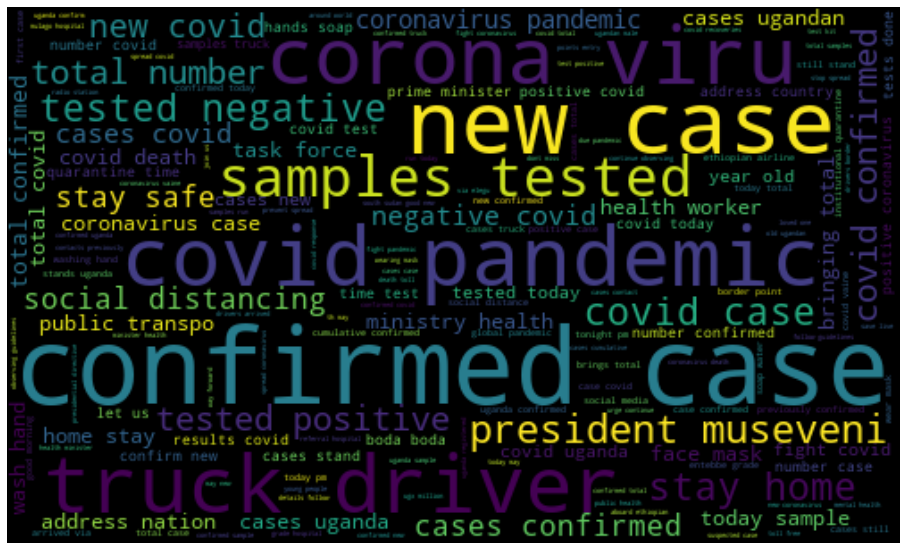

In [47]:
from wordcloud import WordCloud

from collections import Counter
#word cloud from the previous analysis
# word cloud visualization
allWords = ' '.join([twts for twts in twen['preprocess_str']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.figure(figsize=(16,10))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## N-grams:

In this analysis we are trying to find out the most used combination of words. Our data was so much that we could not do anything less than 30-grams.

In [48]:
len(allWords)

97956637

In [49]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from nltk.tokenize import word_tokenize 

In [50]:
# Getting trigrams  
vectorizer = CountVectorizer(ngram_range = (30,30)) 
X1 = vectorizer.fit_transform(twen['preprocess_str'])  
features = (vectorizer.get_feature_names()) 
print("\n\nFeatures : \n", features) 
print("\n\nX1 : \n", X1.toarray()) 



Features : 
 ['aan hadda caasimadeeda joogo maalintii dadku waa shaqaystaan oo qofkasta nolol maalmeedkiisa ayuu la soo baxaa laakiin marka la gaadho pm waa bandow maalintii meelaha layskugu yimaado sida masaajidakiniisada iyo', 'aan jaamacada isla dhigano saaxiibna nahay baa wuxuu igu yiri hadii wiil magiciisa aad garan waydo oo doonayso inaad yeeo muxamed ama cali ugu yeer wuu kuu soo jeesaniye somali', 'aap govts separate markaz category amp manish tewaris muslims silent tablighi jamaat meltdown pa trend anti muslim sentiment toxic right feel compelled echo even statist way else would mean alienating', 'aba nrm mwe abaleese corona virus doctor jane ruth aceng spear head fight gave country go ahead openly gathering multitudes anitemukula musevenis brother senior nrm state favored guys openly gathering', 'abaana bakubye ssente za corona anyway effective th april ill joining ldu serve nation passion clowning health sector may concern please aord necessary suppo tenure ldu god bless b

In [51]:
# Applying TFIDF 
vectorizer = TfidfVectorizer(ngram_range = (30,30)) 
X2 = vectorizer.fit_transform(twen['preprocess_str']) 
scores = (X2.toarray()) 
print("\n\nScores : \n", scores)



Scores : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [52]:
# Getting top ranking features 
sums = X2.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0,col] )) 
ranking = pd.DataFrame(data1, columns = ['term','rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords head : \n", words.head(15)) 


"""
This here below represents a combination of words and how many times that combination was used in 
our text corpus. The idea is to rank the most used say: sentence in this analysis: so the rank 
tells us how that sentence was used.
"""



Words head : 
                                                    term        rank
920   emmanuel tegu third year vet student muk found...  425.000000
306   body weak amp pain soul strong love yall take ...  179.605122
3128  weak amp pain soul strong love yall take guide...  179.605122
1065  forgive sins amp grant us ease time distress a...  117.168922
96    almighty forgive sins amp grant us ease time d...  117.168922
958   every employed ugandan contributed sh could go...  114.000000
2896  ugandans please adhere governments directive c...   97.580736
746   dear ugandans please adhere governments direct...   97.580736
1820  months since ive seen boo damn pandemic amp bo...   86.000000
3005  us tranquility amp hope pandemic seems far man...   68.815379
1196  grant us tranquility amp hope pandemic seems f...   68.815379
97    almighty grant us tranquility amp hope pandemi...   68.165434
1406  ismails lonely funeral relatives keep two metr...   66.000000
2537  sins amp grant us ease ti

# Natural Language Processing

Below we apply the methods of NLP. Please note that these are not all there are, the methods are limited by the scope of the project that we are working on.

I have a wish to use methods like vader. There are many articles on this online.

In [ ]:
 from textblob import TextBlob

In [55]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

NB: The cell below really takes a long time to run. If you have a huge dataset please prepare early.

In [56]:
# Create two new columns 'Subjectivity' & 'Polarity'

twen['Subjectivity'] = twen['preprocess_str'].apply(getSubjectivity)
twen['Polarity'] = twen['preprocess_str'].apply(getPolarity)

In [57]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
          return 'Negative'
    elif score == 0:
          return 'Neutral'
    else:
          return 'Positive'

twen['Analysis'] = twen['Polarity'].apply(getAnalysis)

In [58]:
twen.head(3)

Tweet Id                time  \
date                                                             
2020-10-15 23:17:21  "1316880875116761088" 2020-10-15 23:17:21   
2020-10-15 21:22:37  "1316852001716797440" 2020-10-15 21:22:37   
2020-10-15 20:48:20  "1316843372569657346" 2020-10-15 20:48:20   

                                                                  text  \
date                                                                     
2020-10-15 23:17:21  RT @Tim_jbo: #SkyNewsAust being completely tru...   
2020-10-15 21:22:37  RT @AAssimwe: “What makes @NRMOnline financial...   
2020-10-15 20:48:20  “What makes @NRMOnline financially secure to t...   

                    Retweeted Screen Name Tweet Type               Client  \
date                                                                        
2020-10-15 23:17:21               Tim_jbo    ReTweet                  NaN   
2020-10-15 21:22:37              AAssimwe    ReTweet  Twitter for Android   
2020-10-15 20:48:20                   NaN      Tweet   Twitter for iPhone   

                    Retweets Received Favourites Received   Tweet Location  \
date                                                                         
2020-10-15 23:17:21                 0                   0  Kampala, Uganda   
2020-10-15 21:22:37                 0                   0  Kampala, Uganda   
2020-10-15 20:48:20                 9                  16           UGANDA   

                    Tweet Language  ... User Account Creation Date  \
date                                ...                              
2020-10-15 23:17:21        English  ...       12 Aug 2020 11:30:19   
2020-10-15 21:22:37        English  ...       22 Dec 2018 09:03:55   
2020-10-15 20:48:20        English  ...       10 Sep 2014 10:42:48   

                            Day  Hour   WeekDay  Month  \
date                                                     
2020-10-15 23:17:21  2020-10-15  23.0  Thursday   10.0   
2020-10-15 21:22:37  2020-10-15  21.0  Thursday   10.0   
2020-10-15 20:48:20  2020-10-15  20.0  Thursday   10.0   

                                                       preprocess_data  \
date                                                                     
2020-10-15 23:17:21  [completely, truthful, whats, behind, great, r...   
2020-10-15 21:22:37  [makes, financially, secure, extent, continuou...   
2020-10-15 20:48:20  [makes, financially, secure, extent, continuou...   

                                                        preprocess_str  \
date                                                                     
2020-10-15 23:17:21  completely truthful whats behind great reset g...   
2020-10-15 21:22:37  makes financially secure extent continuously p...   
2020-10-15 20:48:20  makes financially secure extent continuously p...   

                    Subjectivity Polarity  Analysis  
date                                                 
2020-10-15 23:17:21       0.6500     0.30  Positive  
2020-10-15 21:22:37       0.7375    -0.05  Negative  
2020-10-15 20:48:20       0.7375    -0.05  Negative  

[3 rows x 27 columns]

<AxesSubplot:title={'center':'General Sentiments'}>

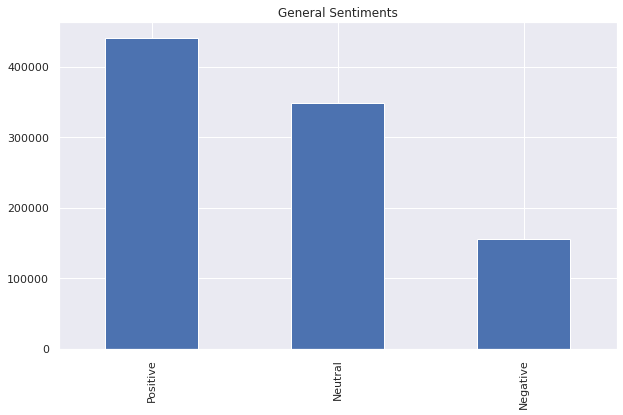

In [59]:
plt.figure(figsize = (10,6))
plt.title("General Sentiments")
twen.Analysis.value_counts().plot(kind = 'bar')

Text(0, 0.5, 'Frequency')

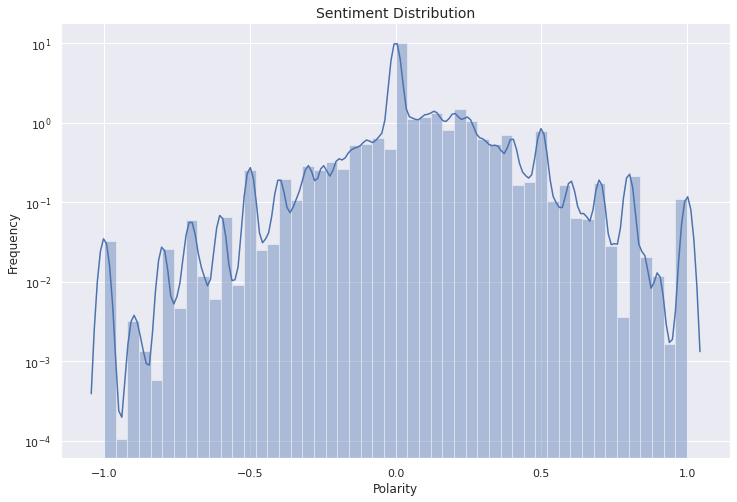

In [96]:
#sentiment distribution

#plot the distribution of the sentiment

plt.figure(figsize=(12,8))
sns.distplot(twen['Polarity'])
plt.yscale('log')
plt.title("Sentiment Distribution",{'size':14})
plt.ylabel("Frequency")

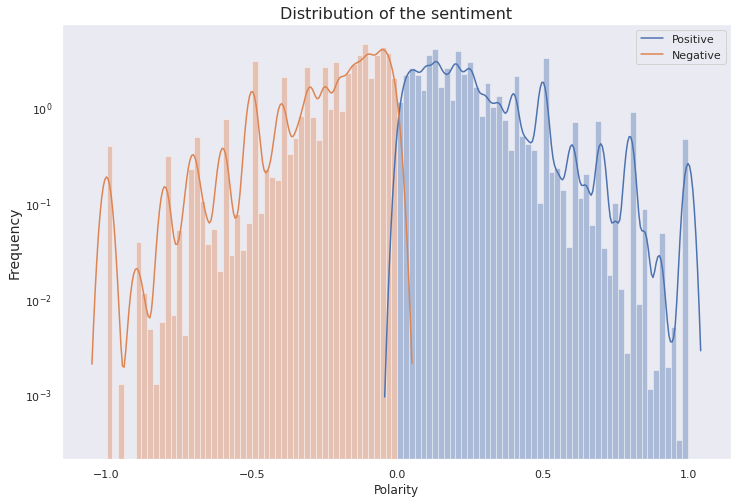

In [99]:
#split the label datasets
z = twen[twen['Analysis']=='Positive']
v = twen[twen['Analysis']=='Negative']

plt.figure(figsize=(12,8))
sns.distplot(z['Polarity'], label = 'Positive')
sns.distplot(v['Polarity'], label = 'Negative')
plt.yscale('log')
plt.title("Distribution of the sentiment", {'size':16})
plt.grid()
plt.ylabel("Frequency", {'size':14})
plt.legend(['Positive','Negative'])


In [60]:
#weekly polarity
#tm = data['Polarity'].resample('1 B').mean()
tmd = twen['Polarity'].resample('1 D').mean()
tmw = twen['Polarity'].resample('1 W').mean()
tmm = twen['Polarity'].resample('1 M').mean()


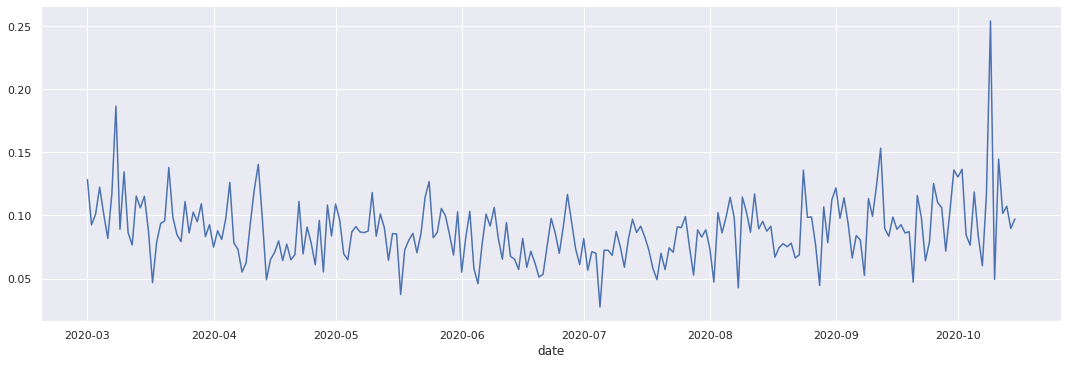

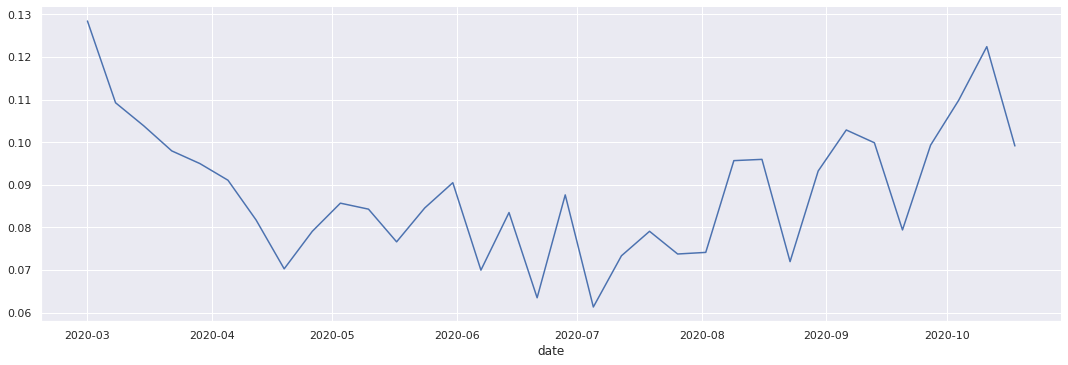

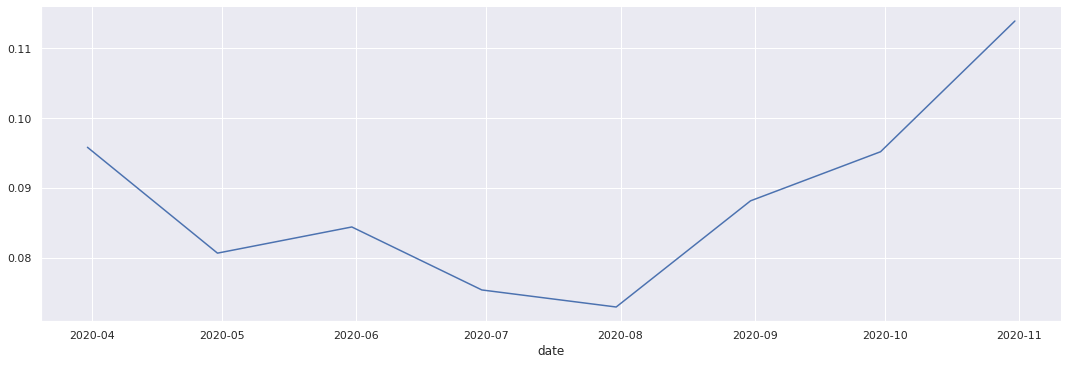

In [61]:
#sns.relplot(x=tm.index, y=tm.values, kind="line",aspect=3 ,data=tm)
sns.relplot(x=tmd.index, y=tmd.values, kind="line",aspect=3 ,data=tmd)
sns.relplot(x=tmw.index, y=tmw.values, kind="line",aspect=3 ,data=tmw)
sns.relplot(x=tmm.index, y=tmm.values, kind="line",aspect=3 ,data=tmm)
# plt.title("Timeseries of Polarity, Daily, Weekly And Monthly")


In [62]:
#this is taking out information that have the word corona in it
twen['corona'] = check_word_in_tweet('corona',twen)

mean_coronax = twen['corona'].resample('M').mean()

Text(0.5, 1.0, 'Time Series showing the count of corona related tweets over the months')

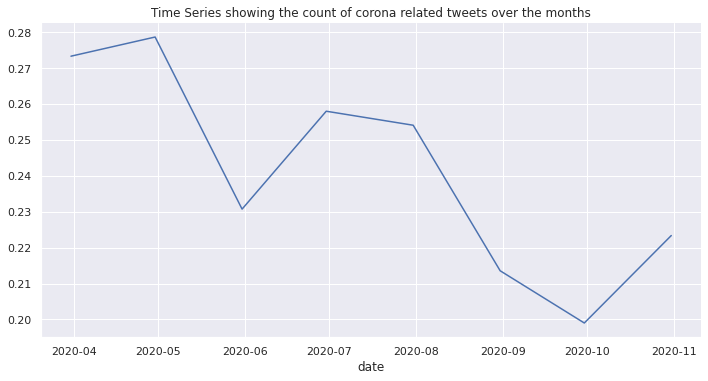

In [63]:
sns.relplot(x=mean_coronax.index, y=mean_coronax.values, kind="line",aspect=2 ,data=tmm)
plt.title("Time Series showing the count of corona related tweets over the months")

#I am not seeing the results for the month of march and April, could it mean that the results that are there are not
#computing properly?

#This graph shows the count of all the tweets that have corona in them

In [64]:
mean_coronaw = twen['corona'].resample('W').mean()
mean_coronad = twen['corona'].resample('D').mean()

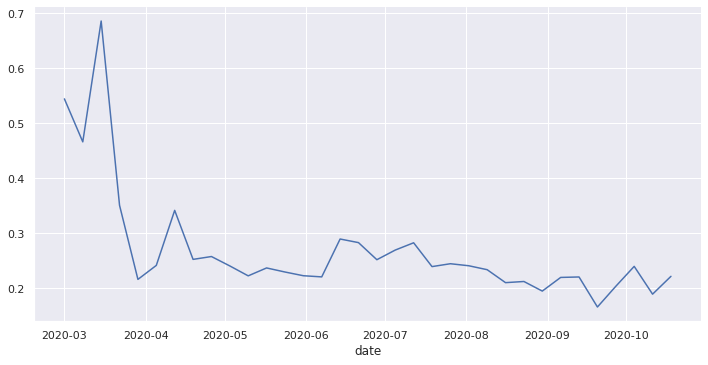

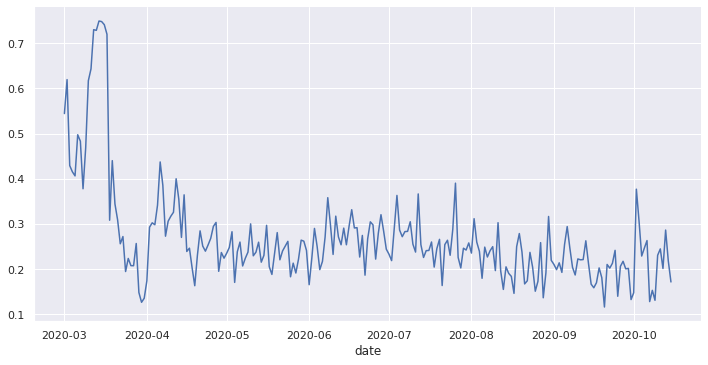

In [65]:
sns.relplot(x=mean_coronaw.index, y=mean_coronaw.values, kind="line",aspect=2 ,data=tmm)
sns.relplot(x=mean_coronad.index, y=mean_coronad.values, kind="line",aspect=2 ,data=tmm)


Text(1.9599999999999937, 0.5, 'Value')

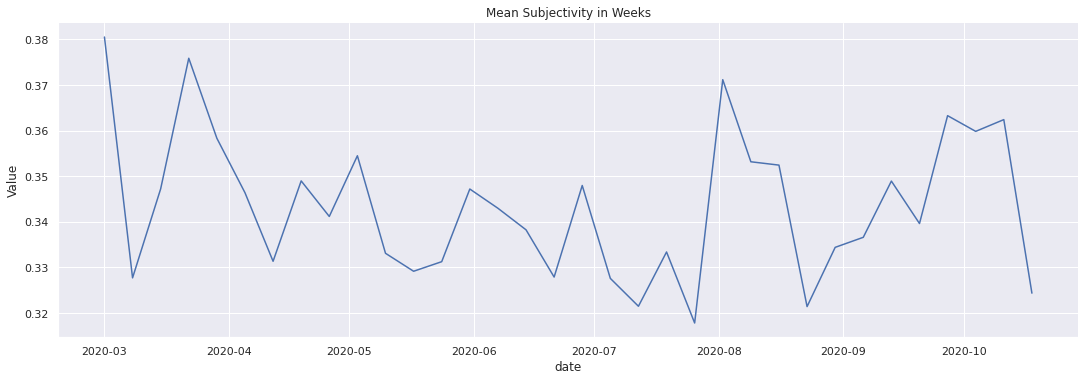

In [66]:
#draw the general subjectivity over time
#draw the general subjectivity over time

sub = twen['Subjectivity'].resample('1 W').mean()
sns.relplot(x=sub.index, y=sub.values, kind="line",aspect=3 ,data=tmd)
plt.title("Mean Subjectivity in Weeks")
plt.ylabel("Value")

In [ ]:
#should draw subjectivity vs polarity on the same axis

#I shall continue from here to look at other forms of graphs that I am going to draw.

#I will be looking at the proper text analysis notebook

In [ ]:
#working with the covid cases

In [68]:
cases = pd.read_csv('covid_cases.csv')

In [69]:
cases.Date = pd.to_datetime(cases['Date'])

In [70]:
cases.set_index('Date',inplace=True)

In [71]:
cases.head(3)

Reported Confirmed Cases  Number of Deaths
Date                                                  
2020-03-01                       0.0               0.0
2020-03-02                       0.0               0.0
2020-03-03                       0.0               0.0

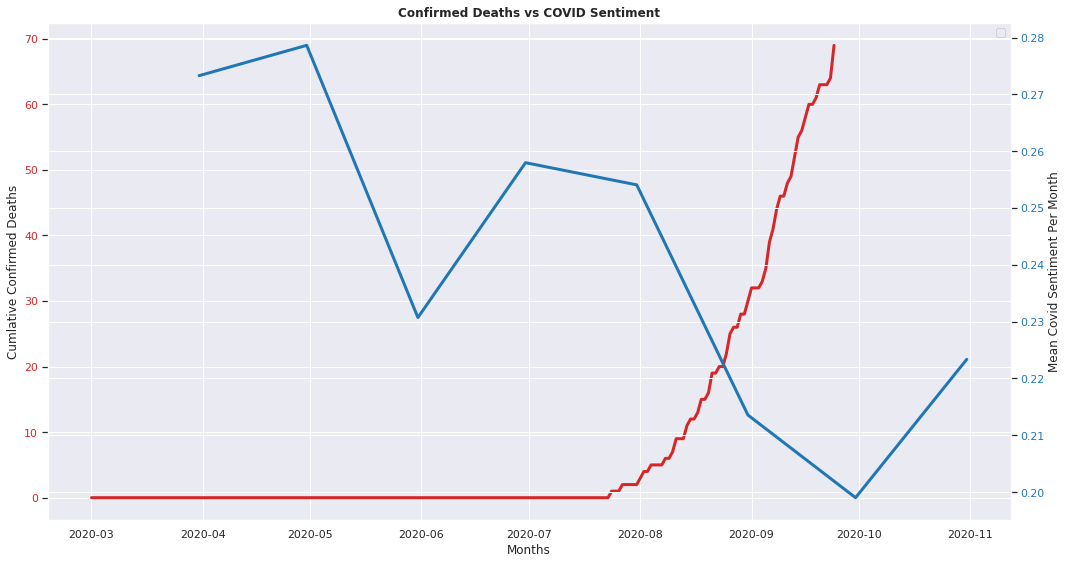

In [72]:
# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(15)

color = 'tab:red'
ax1.set_xlabel('Months', fontsize=12)
ax1.set_ylabel('Cumlative Confirmed Deaths', fontsize=12)
l1 = ax1.plot(cases.index,np.cumsum(cases['Number of Deaths']), color=color, linewidth = 3)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mean Covid Sentiment Per Month', fontsize=12)  # we already handled the x-label with ax1
l2 = ax2.plot(mean_coronax.index,mean_coronax.values, color=color, linewidth = 3)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Confirmed Deaths vs COVID Sentiment",fontweight = 'bold') #make the titles bold


#legend
plt.legend([l1, l2],['Cumlative Confirmed Deaths', 'Mean Covid Sentiment Per Month'],loc="upper right")
#make the axes thicker.
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# We change the fontsize of minor ticks label 

ax1.tick_params(axis='both', which='minor', labelsize=7)

plt.show()

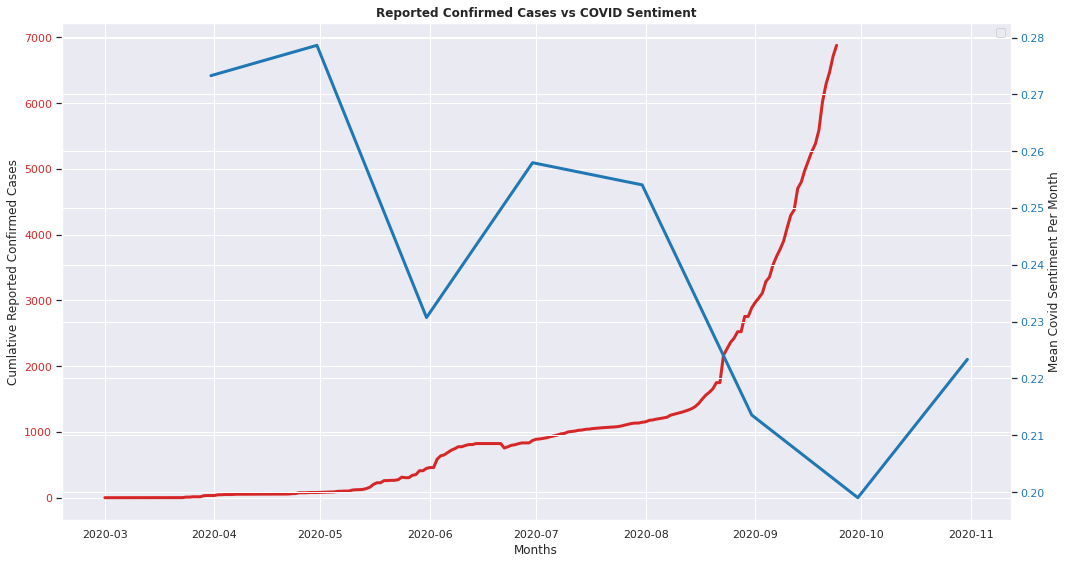

In [73]:
# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(15)

color = 'tab:red'
ax1.set_xlabel('Months', fontsize=12)
ax1.set_ylabel('Cumlative Reported Confirmed Cases', fontsize=12)
l1 = ax1.plot(cases.index,np.cumsum(cases['Reported Confirmed Cases']), color=color, linewidth = 3)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mean Covid Sentiment Per Month', fontsize=12)  # we already handled the x-label with ax1
l2 = ax2.plot(mean_coronax.index,mean_coronax.values, color=color, linewidth = 3)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Reported Confirmed Cases vs COVID Sentiment",fontweight = 'bold') #make the titles bold

#legend
plt.legend([l1, l2],['Cumlative Confirmed Deaths', 'Mean Covid Sentiment Per Month'],loc="upper right")
#make the axes thicker.
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# We change the fontsize of minor ticks label 

ax1.tick_params(axis='both', which='minor', labelsize=7)

plt.show()

Text(0.5, 1.0, 'Cumlative Reported Confirmed Cases')

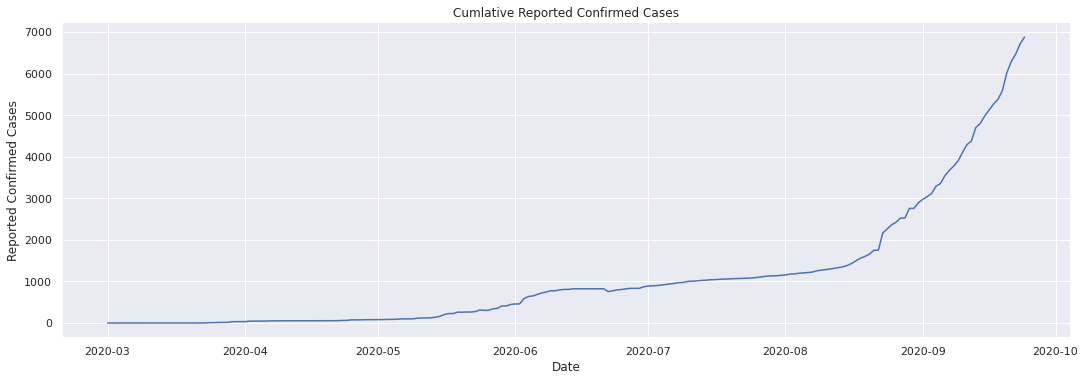

In [74]:
sns.relplot(x=cases.index, y = np.cumsum(cases['Reported Confirmed Cases']),kind='line', data=cases, aspect=3)
plt.title('Cumlative Reported Confirmed Cases')

In [76]:
#resample by weeks cases
cases_conf = cases['Reported Confirmed Cases'].resample('1 W').mean()
death_conf = cases['Number of Deaths'].resample('1 W').mean()
#resample by weeks polarity
polarity = twen['Polarity'].resample('1 W').mean()
Subjectivity = twen['Subjectivity'].resample('1 W').mean()

In [77]:
cases_conf.shape, death_conf.shape, polarity.shape, Subjectivity.shape

((33,), (33,), (34,), (34,))

Text(1.9599999999999937, 0.5, 'Sentiment')

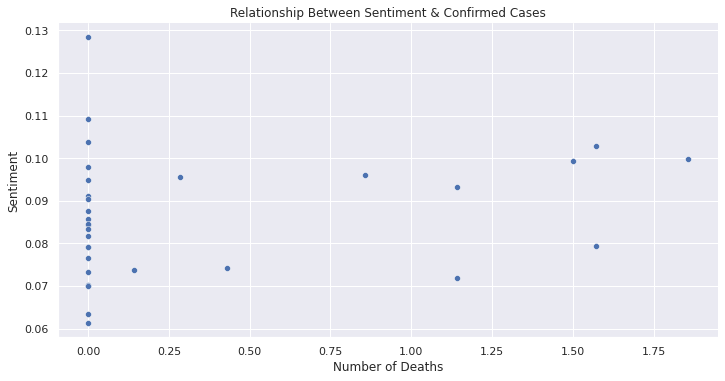

In [80]:
sns.relplot(x = death_conf.values, y = polarity.values[:33], aspect=2)
plt.title("Relationship Between Sentiment & Confirmed Cases")
plt.xlabel("Number of Deaths")
plt.ylabel("Sentiment")

In [94]:
#the reasons I am taking only the first thirty values is because I have some nas in the death values
#and there in an imbalance in the length of the arrays so I have to choose a matching value 30
np.corrcoef(death_conf.values[:30],polarity.values[:30])

array([[1.       , 0.1564803],
       [0.1564803, 1.       ]])

# Geo Data

Here I am going to split the data based on districts so that we can see which districts are using twitter the most and so we can know where its very active and less active.

### The data was really messy, so Richard took care of cleaning it, He may have the cleaner version of this part of the analysis.

In [106]:
#here I have split the column to take apart what I want and leave the rest

#i should have changed all the data into small caps before running this function on it.
 #-- change the data in small caps otherwise it will cause you issues when combined.

#because when you leave it like this, it takes into account the font style and that doesnt help.

twen['Tweet Location'] = twen['Tweet Location'].str.lower()

In [ ]:
twen['district']= twen['Tweet Location'].apply(lambda x: pd.Series(str(x).split(",")))[0]

In [122]:
list(twen['district'].unique())

['kampala',
 'uganda',
 'kampala@uganda',
 'london/kampala',
 'gulu',
 'jinja',
 'mbarara',
 'mbale',
 'kampala - uganda ',
 'हम बिहार से है',
 'kampala- uganda',
 'kampala uganda',
 'kampala - uganda',
 'ntinda | uganda',
 'wakiso',
 'lira',
 'entebbe',
 'uganda ',
 'uganda🇺🇬',
 'brookhaven',
 'kampala-uganda',
 'juba',
 'ebb',
 'kisoro',
 'kampala ',
 'kabale',
 'canada/uganda',
 ' uganda',
 'somerset / kenya / uganda',
 'mukono',
 'fort portal ',
 'busia',
 'uganda - east africa',
 'arua',
 'soroti',
 'ibanda uganda ',
 'kayunga',
 'mityana',
 'masaka born😌',
 'uk & uganda',
 'kampala -uganda',
 'uganda/ 🇩🇪',
 'entebbe uganda',
 'kyeirumba',
 'tororo',
 'nairobi',
 'koboko',
 'uganda kampala',
 'ug ',
 'bugolobi',
 'fortportal',
 'mombasa',
 'uganda - kampala',
 'kampala ug',
 'africa',
 'emirates',
 'uganda red cross society national headquarters',
 'global citizen',
 'masaka',
 'bushenyi',
 'rwanda',
 'iganga',
 'fort portal',
 'somewhere in uganda',
 'uganda 🇺🇬 - born & bred',
 '

In [112]:
twen['district'].str.replace('uganda','kampala')

twen['district'].str.replace(' uganda','kampala')
twen['district'].str.replace('uganda - east africa','kampala')
twen['district'].str.replace('ibanda uganda ','ibanda')
twen['district'].str.replace('uganda','kampala')

twen['district'].str.replace('uganda ','kampala')
twen['district'].str.replace('uganda🇺🇬','kampala')
twen['district'].str.replace('ebb','entebbe')
twen['district'].str.replace('kampala -uganda','kampala')
twen['district'].str.replace('masaka born😌','masaka')
twen['district'].str.replace('uganda/ 🇩🇪','kampala')
twen['district'].str.replace('uganda kampala','kampala')
twen['district'].str.replace('ug ','kampala')
twen['district'].str.replace('bugolobi','kampala')
twen['district'].str.replace('uganda - kampala','kampala')
twen['district'].str.replace('kampala@uganda','kampala')


twen['district'].str.replace('kampala@uganda','kampala')
twen['district'].str.replace('kampala - uganda ','kampala')
twen['district'].str.replace('kampala- uganda','kampala')
twen['district'].str.replace('kampala uganda','kampala')
twen['district'].str.replace('kampala - uganda','kampala')
twen['district'].str.replace('ntinda | uganda','kampala')
twen['district'].str.replace('ntinda | uganda','kampala')




date
2020-10-15 23:17:21           kampala
2020-10-15 21:22:37           kampala
2020-10-15 20:48:20            uganda
2020-10-15 19:01:46    kampala@uganda
2020-10-15 18:15:54    london/kampala
                            ...      
2020-03-01 04:45:22           kampala
2020-03-01 04:45:05           kampala
2020-03-01 03:49:44           kampala
2020-03-01 00:38:23           kampala
2020-03-01 00:19:46           kampala
Name: district, Length: 944463, dtype: object

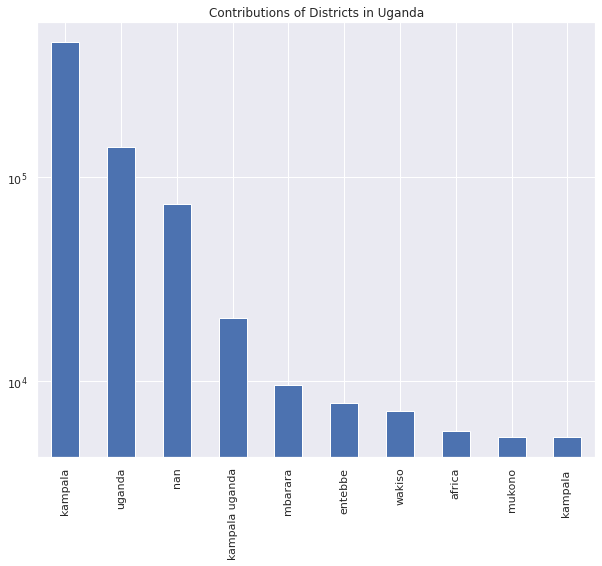

In [121]:
#let us now see where the most people are from
plt.figure(figsize=(10,8))
twen.district.value_counts()[:10].plot(kind='bar')
plt.title("Contributions of Districts in Uganda")
plt.yscale('log')

In [ ]:
#I need to clean the text in the districts in order to get more informative data
# a lot of the data is disorganized and causes the bar-chart to look weird.

# Influencer Analysis

I will run this last because it takes a lot of time to run.

In [150]:
twen.head(2)

Tweet Id                time  \
date                                                             
2020-10-15 23:17:21  "1316880875116761088" 2020-10-15 23:17:21   
2020-10-15 21:22:37  "1316852001716797440" 2020-10-15 21:22:37   

                                                                  text  \
date                                                                     
2020-10-15 23:17:21  RT @Tim_jbo: #SkyNewsAust being completely tru...   
2020-10-15 21:22:37  RT @AAssimwe: “What makes @NRMOnline financial...   

                    Retweeted Screen Name Tweet Type               Client  \
date                                                                        
2020-10-15 23:17:21               Tim_jbo    ReTweet                  NaN   
2020-10-15 21:22:37              AAssimwe    ReTweet  Twitter for Android   

                    Retweets Received Favourites Received   Tweet Location  \
date                                                                         
2020-10-15 23:17:21                 0                   0  Kampala, Uganda   
2020-10-15 21:22:37                 0                   0  Kampala, Uganda   

                    Tweet Language  ...  Hour   WeekDay Month  \
date                                ...                         
2020-10-15 23:17:21        English  ...  23.0  Thursday  10.0   
2020-10-15 21:22:37        English  ...  21.0  Thursday  10.0   

                                                       preprocess_data  \
date                                                                     
2020-10-15 23:17:21  [completely, truthful, whats, behind, great, r...   
2020-10-15 21:22:37  [makes, financially, secure, extent, continuou...   

                                                        preprocess_str  \
date                                                                     
2020-10-15 23:17:21  completely truthful whats behind great reset g...   
2020-10-15 21:22:37  makes financially secure extent continuously p...   

                    Subjectivity  Polarity  Analysis corona  follow_ratio  
date                                                                       
2020-10-15 23:17:21       0.6500      0.30  Positive  False      0.738255  
2020-10-15 21:22:37       0.7375     -0.05  Negative  False      0.263479  

[2 rows x 29 columns]

In [149]:
twen.columns

Index(['Tweet Id', 'time', 'text', 'Retweeted Screen Name', 'Tweet Type',
       'Client', 'Retweets Received', 'Favourites Received', 'Tweet Location',
       'Tweet Language', 'Name', 'Screen Name', 'Verified or Non-Verified',
       'User Followers', 'User Following', 'Favourites Count',
       'Statuses Count', 'User Account Creation Date', 'Day', 'Hour',
       'WeekDay', 'Month', 'preprocess_data', 'preprocess_str', 'Subjectivity',
       'Polarity', 'Analysis', 'corona', 'follow_ratio'],
      dtype='object')

In [196]:
sotu_retweetsx = twen[['Screen Name','Retweeted Screen Name']]

In [197]:
sotu_retweetsx.dropna(inplace=True)

In [153]:
#import the necessary library
import networkx as nx

In [198]:
# Create retweet network from edgelist
G_rtx = nx.from_pandas_edgelist(
    sotu_retweetsx,
    source = 'Screen Name', 
    target = 'Retweeted Screen Name',
    create_using = nx.DiGraph())
    
# Print the number of nodes
print('Nodes in RT network:', len(G_rtx.nodes()))

# Print the number of edges
print('Edges in RT network:', len(G_rtx.edges()))

Nodes in RT network: 93107
Edges in RT network: 390184


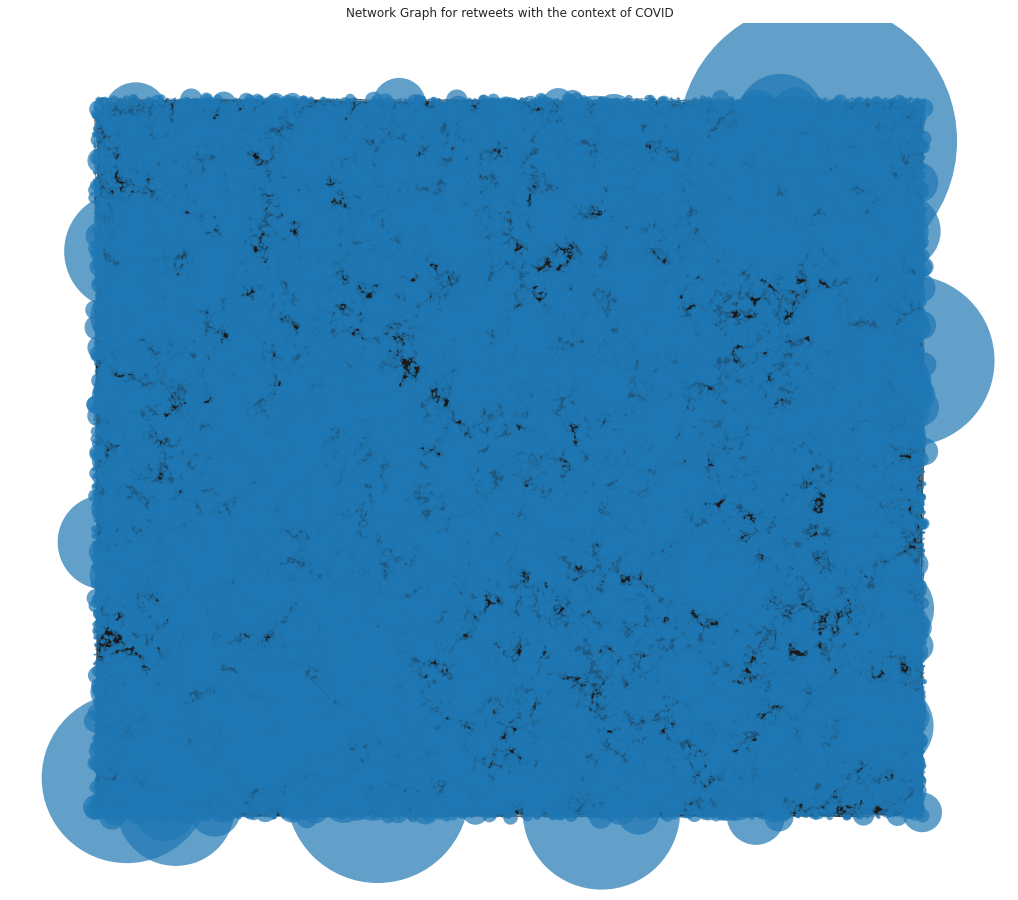

In [157]:
# Create random layout positions
plt.figure(figsize= (18,16))
plt.title('Network Graph for retweets with the context of COVID')
pos = nx.random_layout(G_rt)

# Create size list
sizes = [5*(x[1]) for x in G_rt.degree()]

# Draw the network
nx.draw_networkx(G_rt, pos, 
    with_labels = False, 
    node_size = sizes,
    width = 0.5, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

# Turn axis off and show
plt.axis('off'); plt.show()

#we can see that there are some major players in these retweet graphs.
#we can make more sense of this in a way that we can see who the big players are
#what they are talking about in this time.


In [200]:
column_names = ['screen_name', 'degree_centrality']
# Generate in-degree centrality for retweets 
rt_centrality = nx.in_degree_centrality(G_rtx)

# Store centralities in DataFrame
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)

# Print first five results in descending order of centrality
print(rt.sort_values('degree_centrality', ascending = False).head())


         screen_name  degree_centrality
940            nbstv           0.165779
89     MinofHealthUG           0.124600
5324  JaneRuth_Aceng           0.071875
2742  KagutaMuseveni           0.062832
1926       ntvuganda           0.061264


In [204]:
 dfcx = rt.sort_values('degree_centrality', ascending = False).head(10)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

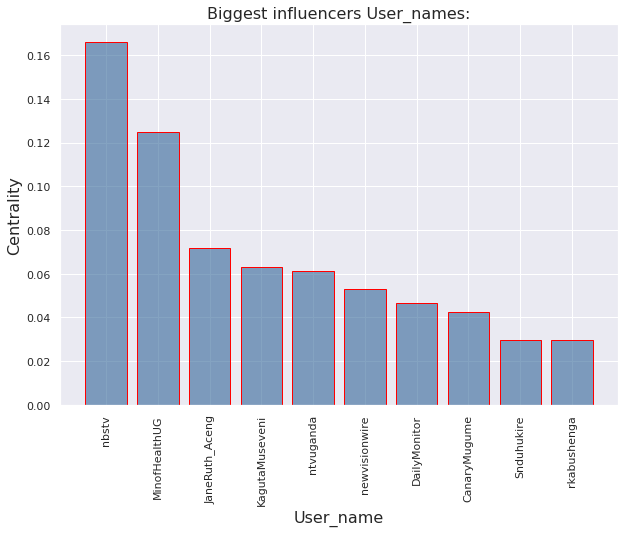

In [205]:
plt.figure(figsize = (10,7))
plt.title('Biggest influencers User_names:', {'size':16})
plt.bar(dfcx['screen_name'],dfcx['degree_centrality'],color=(0.2, 0.4, 0.6, 0.6),edgecolor='red')
plt.xlabel("User_name", {'size':16})
plt.ylabel("Centrality",{'size':16})
plt.xticks(rotation = 90)


In [194]:
#betweeness centrality
#who is the person that is the most important: like a middle person of communication
column_namez = ['screen_name', 'betweenness_centrality']

# Generate betweenness centrality for retweets 
rt_centrality = nx.betweenness_centrality(G_rt)

# Store centralities in data frames
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_namez)

# Print first five results in descending order of centrality
print(rt.sort_values('betweenness_centrality', ascending = False).head())

      screen_name  betweenness_centrality
11  daniellutaaya                0.000787
28       emeka_ug                0.000559
68  OmaraDanielol                0.000432
56    DorahAtwong                0.000402
83    bhannington                0.000332


In [ ]:
 dfc = rt.sort_values('betweenness_centrality', ascending = False).head(10)

In [ ]:
plt.figure(figsize = (10,7))
plt.title('Biggest influencers User_names:', {'size':16})
plt.bar(dfc['screen_name'],dfc['betweenness_centrality'],color=(0.2, 0.4, 0.6, 0.6),edgecolor='red')
plt.xlabel("User_name", {'size':16})
plt.ylabel("Centrality",{'size':16})
plt.xticks(rotation = 90)


# Better Influencer Analysis.

In this section what I considered were some limiting factors on who could show up in my analysis as an influencer, the person needs to have been around for a long time. They need a good engagement ratio and follow ratio.

Therefore such a person would be useful in informing the general public on the basis of covid.

In [123]:
twen.head()

Tweet Id                time  \
date                                                             
2020-10-15 23:17:21  "1316880875116761088" 2020-10-15 23:17:21   
2020-10-15 21:22:37  "1316852001716797440" 2020-10-15 21:22:37   
2020-10-15 20:48:20  "1316843372569657346" 2020-10-15 20:48:20   
2020-10-15 19:01:46  "1316816553480990721" 2020-10-15 19:01:46   
2020-10-15 18:15:54  "1316805012299841537" 2020-10-15 18:15:54   

                                                                  text  \
date                                                                     
2020-10-15 23:17:21  RT @Tim_jbo: #SkyNewsAust being completely tru...   
2020-10-15 21:22:37  RT @AAssimwe: “What makes @NRMOnline financial...   
2020-10-15 20:48:20  “What makes @NRMOnline financially secure to t...   
2020-10-15 19:01:46  RT @ECA_OFFICIAL: About $4.6billion in #DSSI l...   
2020-10-15 18:15:54  Confusing Coronavirus Covid-19 Lockdown measur...   

                    Retweeted Screen Name Tweet Type               Client  \
date                                                                        
2020-10-15 23:17:21               Tim_jbo    ReTweet                  NaN   
2020-10-15 21:22:37              AAssimwe    ReTweet  Twitter for Android   
2020-10-15 20:48:20                   NaN      Tweet   Twitter for iPhone   
2020-10-15 19:01:46          ECA_OFFICIAL    ReTweet      Twitter Web App   
2020-10-15 18:15:54                   NaN      Tweet  Twitter for Android   

                    Retweets Received Favourites Received   Tweet Location  \
date                                                                         
2020-10-15 23:17:21                 0                   0  kampala, uganda   
2020-10-15 21:22:37                 0                   0  kampala, uganda   
2020-10-15 20:48:20                 9                  16           uganda   
2020-10-15 19:01:46                 0                   0   kampala@uganda   
2020-10-15 18:15:54                 0                   0   london/kampala   

                    Tweet Language  ...  Hour   WeekDay Month  \
date                                ...                         
2020-10-15 23:17:21        English  ...  23.0  Thursday  10.0   
2020-10-15 21:22:37        English  ...  21.0  Thursday  10.0   
2020-10-15 20:48:20        English  ...  20.0  Thursday  10.0   
2020-10-15 19:01:46        English  ...  19.0  Thursday  10.0   
2020-10-15 18:15:54        English  ...  18.0  Thursday  10.0   

                                                       preprocess_data  \
date                                                                     
2020-10-15 23:17:21  [completely, truthful, whats, behind, great, r...   
2020-10-15 21:22:37  [makes, financially, secure, extent, continuou...   
2020-10-15 20:48:20  [makes, financially, secure, extent, continuou...   
2020-10-15 19:01:46  [billion, liquidity, enabled, countries, respo...   
2020-10-15 18:15:54  [confusing, coronavirus, covid, lockdown, meas...   

                                                        preprocess_str  \
date                                                                     
2020-10-15 23:17:21  completely truthful whats behind great reset g...   
2020-10-15 21:22:37  makes financially secure extent continuously p...   
2020-10-15 20:48:20  makes financially secure extent continuously p...   
2020-10-15 19:01:46  billion liquidity enabled countries respond qu...   
2020-10-15 18:15:54  confusing coronavirus covid lockdown measures ...   

                    Subjectivity  Polarity  Analysis corona        district  
date                                                                         
2020-10-15 23:17:21     0.650000  0.300000  Positive  False         kampala  
2020-10-15 21:22:37     0.737500 -0.050000  Negative  False         kampala  
2020-10-15 20:48:20     0.737500 -0.050000  Negative  False          uganda  
2020-10-15 19:01:46     0.633333  0.544444  Positive  False  kampala@uganda  
202

In [124]:
twen.columns

Index(['Tweet Id', 'time', 'text', 'Retweeted Screen Name', 'Tweet Type',
       'Client', 'Retweets Received', 'Favourites Received', 'Tweet Location',
       'Tweet Language', 'Name', 'Screen Name', 'Verified or Non-Verified',
       'User Followers', 'User Following', 'Favourites Count',
       'Statuses Count', 'User Account Creation Date', 'Day', 'Hour',
       'WeekDay', 'Month', 'preprocess_data', 'preprocess_str', 'Subjectivity',
       'Polarity', 'Analysis', 'corona', 'district'],
      dtype='object')

In [134]:
try:
    twen[['User Followers','User Following','Favourites Count','Statuses Count']] = twen[['User Followers','User Following','Favourites Count','Statuses Count']].fillna(0).astype('int')
except ValueError:
    pass

In [136]:
twen[['User Followers','User Following','Favourites Count','Statuses Count']].head(3)

User Followers  User Following Favourites Count  \
date                                                                   
2020-10-15 23:17:21           894.0           660.0             1529   
2020-10-15 21:22:37           983.0           259.0             3968   
2020-10-15 20:48:20          7322.0          5041.0             5667   

                     Statuses Count  
date                                 
2020-10-15 23:17:21         94125.0  
2020-10-15 21:22:37          5023.0  
2020-10-15 20:48:20         18657.0

In [139]:
#I wrote these codes separate not in a function because I wanted to trace the errors individually
twen['follow_ratio'] = twen['User Following']/twen['User Followers']

In [164]:
# I had to drop one value that had wrong index
twen.drop(index = (twen[twen['Tweet Location']=='smart youth network initiative'].index),inplace=True)

In [167]:
twen['engagement'] = twen['Favourites Count'].astype('float')/twen['Statuses Count']

In [173]:
twen['User Account Creation Date'] = pd.to_datetime(twen['User Account Creation Date'])


In [174]:
twen['acc_age']=2020- twen['User Account Creation Date'].dt.year

In [175]:
twen.columns

Index(['Tweet Id', 'time', 'text', 'Retweeted Screen Name', 'Tweet Type',
       'Client', 'Retweets Received', 'Favourites Received', 'Tweet Location',
       'Tweet Language', 'Name', 'Screen Name', 'Verified or Non-Verified',
       'User Followers', 'User Following', 'Favourites Count',
       'Statuses Count', 'User Account Creation Date', 'Day', 'Hour',
       'WeekDay', 'Month', 'preprocess_data', 'preprocess_str', 'Subjectivity',
       'Polarity', 'Analysis', 'corona', 'district', 'follow_ratio',
       'engagement', 'acc_age'],
      dtype='object')

twen.to_csv('updated_data_2',index=False)

In [170]:
twen[['follow_ratio','engagement']].head()

follow_ratio  engagement
date                                         
2020-10-15 23:17:21      0.738255    0.016244
2020-10-15 21:22:37      0.263479    0.789966
2020-10-15 20:48:20      0.688473    0.303747
2020-10-15 19:01:46      2.074658    0.739070
2020-10-15 18:15:54      0.846154    0.098757

In [177]:
infd = twen.loc[(twen.follow_ratio<0.3) & (twen.engagement>1.5) & (twen.acc_age>5)]


In [178]:
infd.shape

(6177, 32)

In [184]:
sotu_retweets = infd[['Screen Name','Retweeted Screen Name']]

In [185]:
sotu_retweets.dropna(inplace=True)

In [186]:
#import the necessary library
import networkx as nx

In [187]:
# Create retweet network from edgelist
G_rt = nx.from_pandas_edgelist(
    sotu_retweets,
    source = 'Screen Name', 
    target = 'Retweeted Screen Name',
    create_using = nx.DiGraph())
    
# Print the number of nodes
print('Nodes in RT network:', len(G_rt.nodes()))

# Print the number of edges
print('Edges in RT network:', len(G_rt.edges()))

Nodes in RT network: 1738
Edges in RT network: 2614


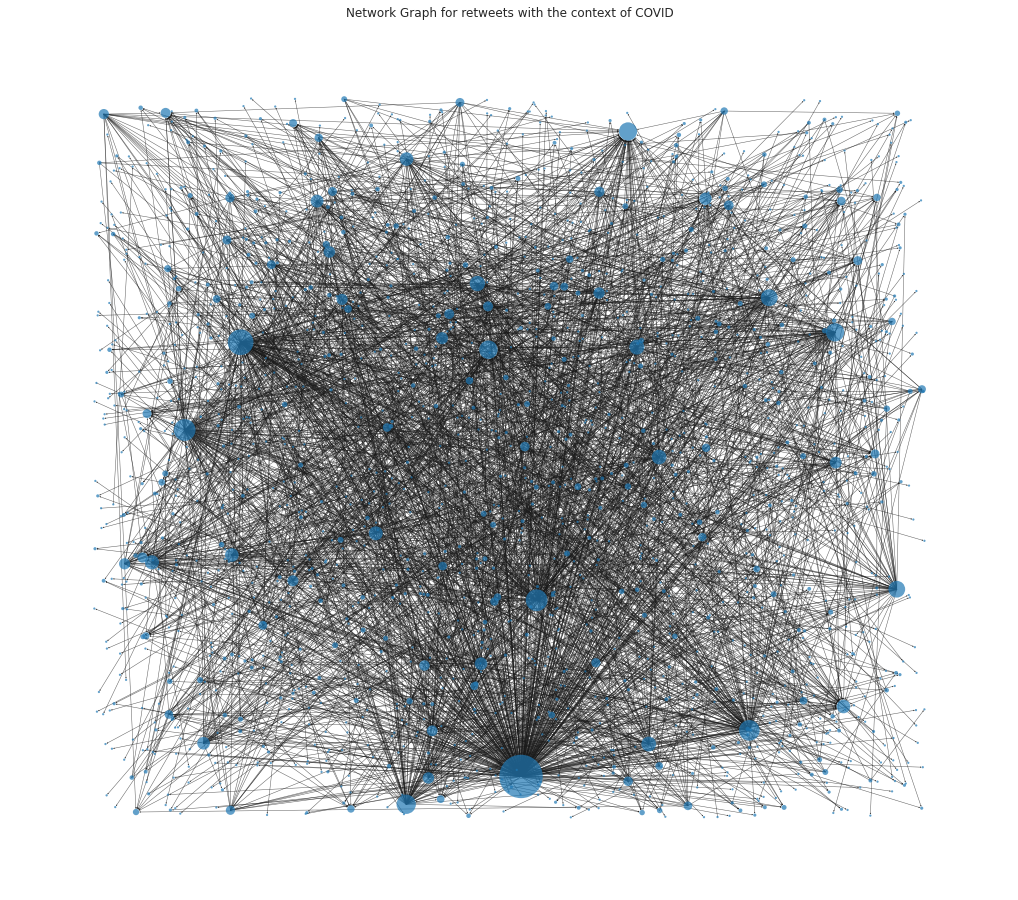

In [188]:
# Create random layout positions
plt.figure(figsize= (18,16))
plt.title('Network Graph for retweets with the context of COVID')
pos = nx.random_layout(G_rt)

# Create size list
sizes = [5*(x[1]) for x in G_rt.degree()]

# Draw the network
nx.draw_networkx(G_rt, pos, 
    with_labels = False, 
    node_size = sizes,
    width = 0.5, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

# Turn axis off and show
plt.axis('off'); plt.show()

#we can see that there are some major players in these retweet graphs.
#we can make more sense of this in a way that we can see who the big players are
#what they are talking about in this time.


In [189]:
column_names = ['screen_name', 'degree_centrality']
# Generate in-degree centrality for retweets 
rt_centrality = nx.in_degree_centrality(G_rt)

# Store centralities in DataFrame
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)

# Print first five results in descending order of centrality
print(rt.sort_values('degree_centrality', ascending = False).head())


        screen_name  degree_centrality
5             nbstv           0.039148
7     MinofHealthUG           0.037997
54   JaneRuth_Aceng           0.021301
48   KagutaMuseveni           0.017847
137       ntvuganda           0.013241


In [190]:
#betweeness centrality
#who is the person that is the most important: like a middle person of communication
column_namez = ['screen_name', 'betweenness_centrality']

# Generate betweenness centrality for retweets 
rt_centrality = nx.betweenness_centrality(G_rt)

# Store centralities in data frames
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_namez)

# Print first five results in descending order of centrality
print(rt.sort_values('betweenness_centrality', ascending = False).head())

      screen_name  betweenness_centrality
11  daniellutaaya                0.000787
28       emeka_ug                0.000559
68  OmaraDanielol                0.000432
56    DorahAtwong                0.000402
83    bhannington                0.000332


In [191]:
 dfc = rt.sort_values('betweenness_centrality', ascending = False).head(10)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

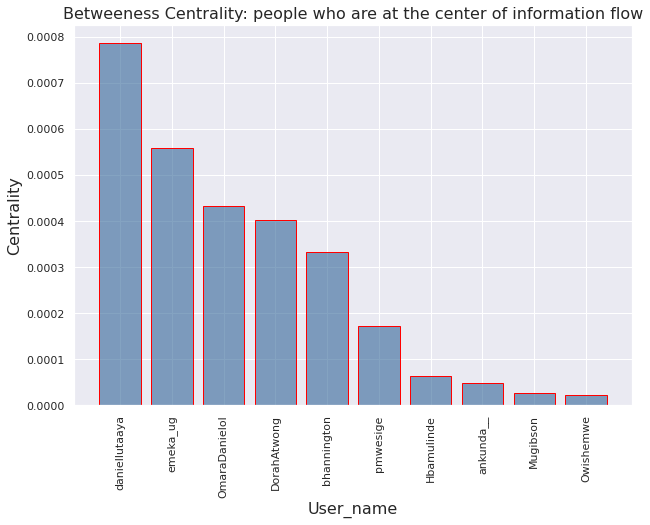

In [193]:
plt.figure(figsize = (10,7))
plt.title('Betweeness Centrality: people who are at the center of information flow', {'size':16})
plt.bar(dfc['screen_name'],dfc['betweenness_centrality'],color=(0.2, 0.4, 0.6, 0.6),edgecolor='red')
plt.xlabel("User_name", {'size':16})
plt.ylabel("Centrality",{'size':16})
plt.xticks(rotation = 90)
